In [1]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [57]:
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def dual_control_sundials(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

def upstream_repression_sundials(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + k2

def downstream_activation_sundials(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = activation(y[1], k2, theta2, n2) + k1

def no_control(t, y, ydot, p):
    n1, n2 = [2., 2.]
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    k1, k2, theta1, theta2 = p
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = k1 - lam*y[2]
    ydot[3] = k2 - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = k1 + k2

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss


In [58]:
space = [hp.uniform('k1', 1E-7, 1E-3), hp.uniform('k2', 1E-7, 1E-3), hp.uniform('theta1', 0.001, 10), hp.uniform('theta2', 0.001, 10)]

In [70]:
losses = []
def objective(param_values):
    #Integration conditions
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])

    #Set architecture
    ode_function = no_control

    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2)
    losses.append(loss)
    return loss

In [11]:
max_iters = [10, 25, 50, 75, 100, 200, 500, 1000, 2000]
best_params = []
best_losses = []
for num_iters in max_iters:
    best = fmin(objective, space, algo=tpe.suggest, max_evals=num_iters)
    best_losses.append(objective(list(best.values())))
    best_params.append(best)

100%|██████████| 2000/2000 [00:53<00:00, 37.32trial/s, best loss: 0.06348770880384288]


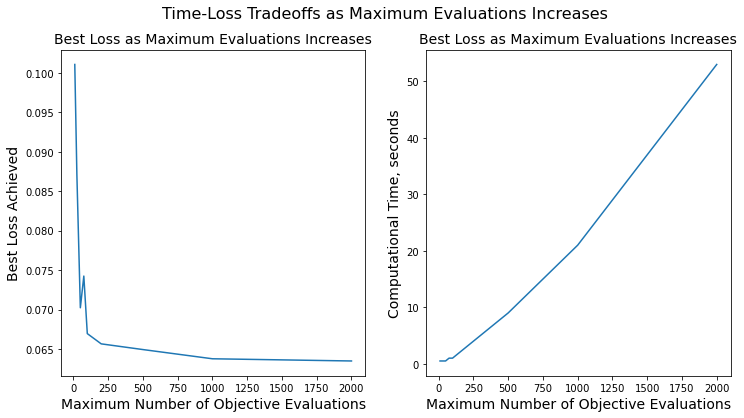

In [19]:
#Manually construct elapsed time figure
elapsed_times = [0.5, 0.5, 0.5, 1, 1, 3, 9, 21, 53]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
endpoint = 'Best Loss as Maximum Evaluations Increases'
ax = axs[0]
ax.plot(max_iters, best_losses)
ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Best Loss as Maximum Evaluations Increases'
ax = axs[1]
ax.plot(max_iters, elapsed_times)
ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Computational Time, seconds', fontsize=14)
ax.set_title(endpoint, fontsize=14)
fig.suptitle('Time-Loss Tradeoffs as Maximum Evaluations Increases', fontsize=16)
fig.savefig('max_evals_time_loss.png')

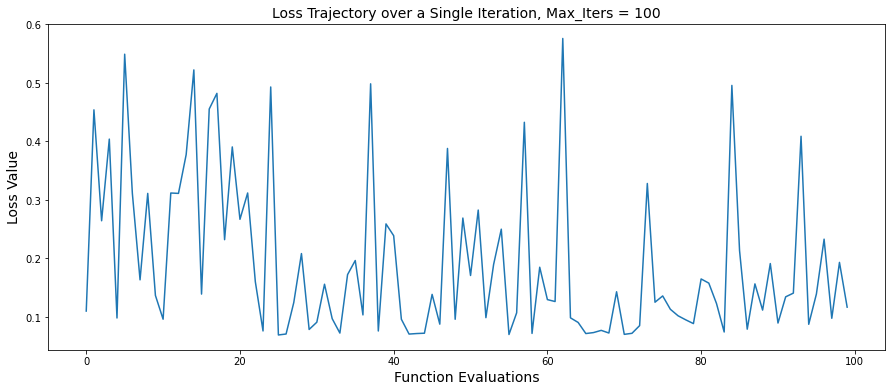

In [26]:
#Losses over a single iteration - shows it jumping around
#best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

fig, axs = plt.subplots(1, 1, figsize=(15, 6))
endpoint = 'Loss Trajectory over a Single Iteration, Max_Iters = 100'
ax = axs
ax.plot(losses)
ax.set_xlabel('Function Evaluations', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_title(endpoint, fontsize=14)
fig.savefig('loss_over_iteration.png')

In [71]:
max_iters = [100, 200, 400, 800]
num_tries = 10

iters_list = []
best_params = []
best_losses = []
for num_iters in max_iters:
    for n in range(num_tries):
        best = fmin(objective, space, algo=tpe.suggest, max_evals=num_iters)
        best_losses.append(objective(list(best.values())))
        best_params.append(best)
        iters_list.append(num_iters)

100%|██████████| 800/800 [00:13<00:00, 58.73trial/s, best loss: 0.0626882735110783]


In [72]:
num_trials_data = pd.DataFrame({'num_iters': iters_list, 'best_losses': best_losses, 'best_params':best_params})
num_trials_data.to_csv('num_trials_data.csv')

In [73]:
num_trials_data = pd.read_csv('num_trials_data.csv')
k1s = []; k2s = []; theta1s = []; theta2s = []
for i in range(len(num_trials_data)):
    d = num_trials_data.best_params[i]
    k1s.append(float(d.split(',')[0].split(':')[-1]))
    k2s.append(float(d.split(',')[1].split(':')[-1]))
    theta1s.append(float(d.split(',')[2].split(':')[-1]))
    theta2s.append(float(d.split(',')[3].split(':')[-1].split('}')[0]))
num_trials_data['k1'] = k1s
num_trials_data['k2'] = k2s
num_trials_data['theta1'] = theta1s
num_trials_data['theta2'] = theta2s

In [74]:
num_trials_data.to_csv('nc_10trials.csv')

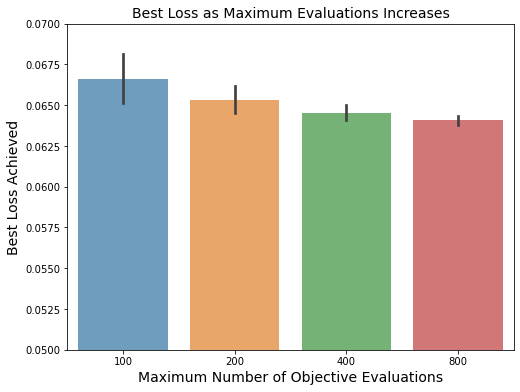

In [48]:
#num_trials_data = pd.read_csv('num_trials_data.csv')
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
endpoint = 'Best Loss as Maximum Evaluations Increases'
ax = axs
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="best_losses", ci="sd", alpha=0.7)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)
ax.set_ylim([0.05, 0.07])
fig.savefig('best_loss_bar_plot.png')

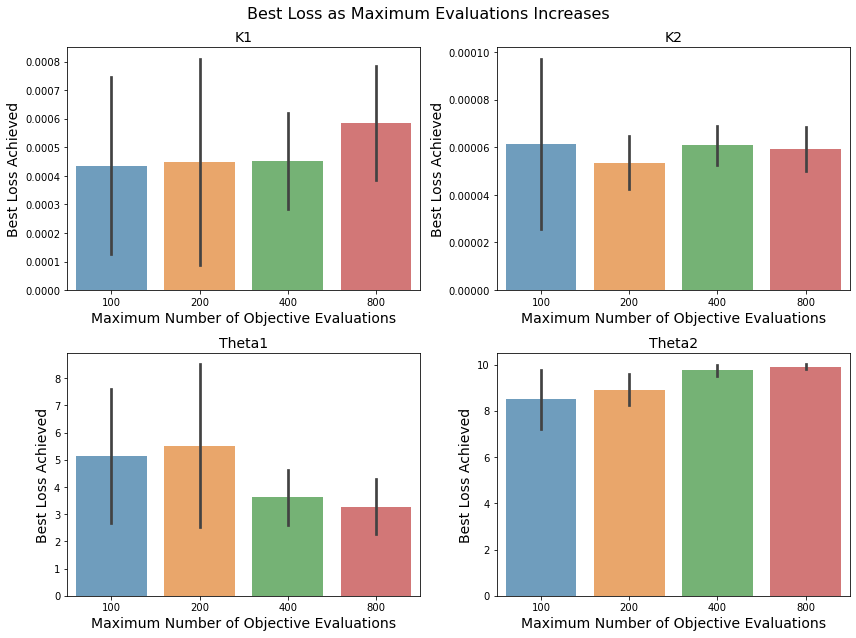

In [47]:

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
endpoint = 'K1'
ax = axs[0][0]
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="k1", ci="sd", alpha=0.7, ax=ax)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'K2'
ax = axs[0][1]
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="k2", ci="sd", alpha=0.7, ax=ax)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Theta1'
ax = axs[1][0]
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="theta1", ci="sd", alpha=0.7, ax=ax)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)

endpoint = 'Theta2'
ax = axs[1][1]
g = sns.barplot(
    data=num_trials_data,
    x="num_iters", y="theta2", ci="sd", alpha=0.7, ax=ax)

ax.set_xlabel('Maximum Number of Objective Evaluations', fontsize=14)
ax.set_ylabel('Best Loss Achieved', fontsize=14)
ax.set_title(endpoint, fontsize=14)
fig.suptitle('Best Loss as Maximum Evaluations Increases', fontsize=16)
fig.tight_layout()
fig.savefig('parameters_max_evals_bar.png')

In [ ]:
max_iters = [100, 200, 400, 800]
num_tries = 10

iters_list = []
best_params = []
best_losses = []
for num_iters in max_iters:
    for n in range(num_tries):
        best = fmin(objective, space, algo=tpe.suggest, max_evals=num_iters)
        best_losses.append(objective(list(best.values())))
        best_params.append(best)
        iters_list.append(num_iters)